In [1]:
# import libraries
import torch
import time
import plot

In [2]:
torch.manual_seed(1) # set random number generator seed (allows to repeat results)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # set computing device (CPU or GPU)
torch.set_default_dtype(torch.float32) # set floating-point precision

In [3]:
# database = 8192 simulations w/ 64x64 resolution
data = torch.load("data.pt", map_location=device) # load data
inputs = data["young_modulus"].view(8192, 1, 64, 64) # select and reshape input data tensor (microstructure)
outputs = data["stress"].select(4, 0).select(1, 0).view(8192, 1, 64, 64) # select and reshape output data tensor (stress distribution, component xx)

In [6]:
data["young_modulus"].shape

torch.Size([8192, 64, 64])

In [4]:
print(data.keys())

dict_keys(['young_modulus', 'fraction', 'stress', 'equivalent_poisson_ratio', 'equivalent_young_modulus'])


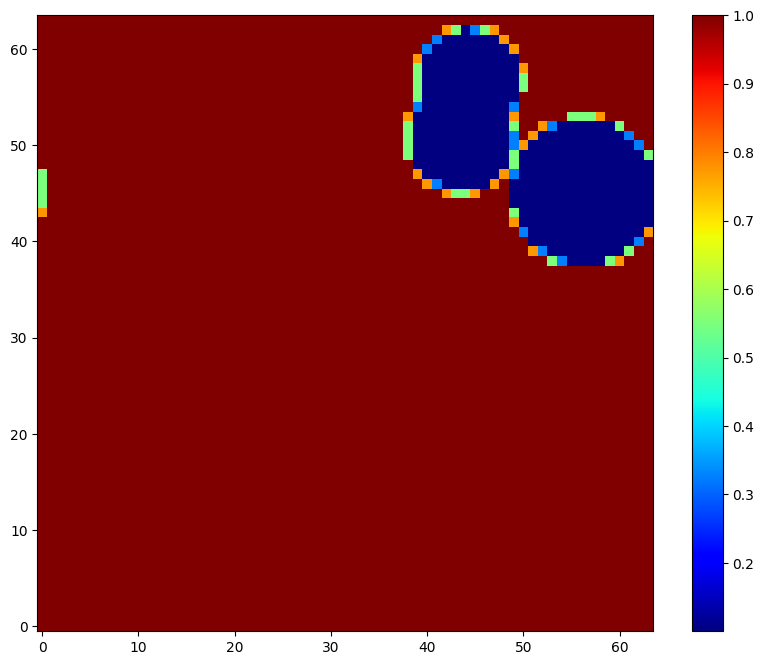

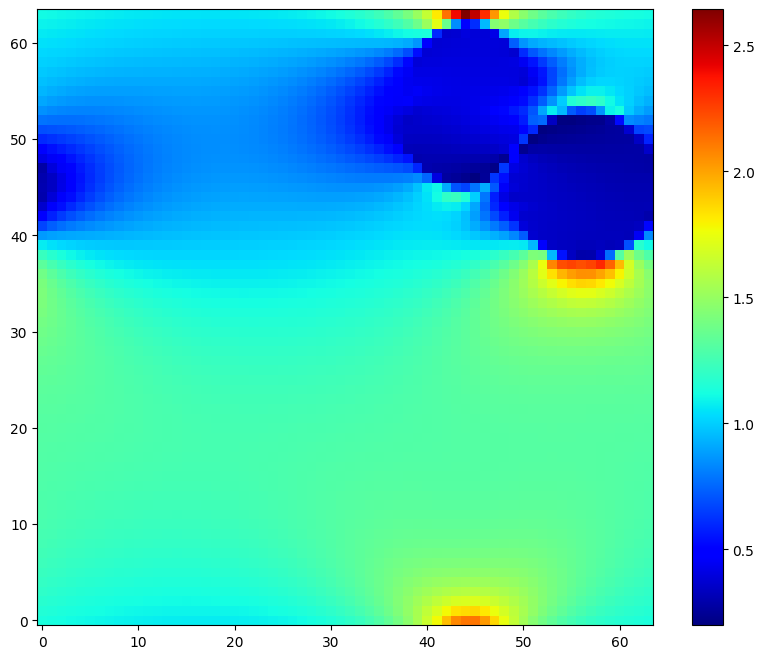

In [3]:
# visualize first sample
plot.surface(inputs[1, 0, ...])
plot.surface(outputs[1, 0, ...])

In [4]:
# ML model architectures

class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.activation = torch.nn.LeakyReLU()

        # input: 64x64, output: 32x32
        self.e11 = torch.nn.Conv2d(1, 4, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.e12 = torch.nn.Conv2d(4, 4, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # input: 32x32, output: 16x16
        self.e21 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.e22 = torch.nn.Conv2d(8, 8, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # input: 16x16, output: 8x8
        self.e31 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.e32 = torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # input: 8x8, output: 4x4
        self.e41 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.e42 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # input: 4x4, output: 4x4
        self.e51 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.e52 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same', padding_mode='circular')


        # Decoder
        # input: 4x4, output: 8x8
        self.upconv1 = torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d11 = torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.d12 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same', padding_mode='circular')

        # input: 8x8, output: 16x16
        self.upconv2 = torch.nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.d21 = torch.nn.Conv2d(32, 16, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.d22 = torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding='same', padding_mode='circular')

        # input: 16x16, output: 32x32
        self.upconv3 = torch.nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.d31 = torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.d32 = torch.nn.Conv2d(8, 8, kernel_size=3, stride=1, padding='same', padding_mode='circular')

        # input: 32x32, output: 64x64
        self.upconv4 = torch.nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.d41 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=1, padding='same', padding_mode='circular')
        self.d42 = torch.nn.Conv2d(4, 4, kernel_size=3, stride=1, padding='same', padding_mode='circular')

        # Output layer 64x64
        self.outconv = torch.nn.Conv2d(4, 1, kernel_size=1)

    def forward(self, x):

        # Encoder
        xe11 = self.activation(self.e11(x))
        xe12 = self.activation(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = self.activation(self.e21(xp1))
        xe22 = self.activation(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = self.activation(self.e31(xp2))
        xe32 = self.activation(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = self.activation(self.e41(xp3))
        xe42 = self.activation(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = self.activation(self.e51(xp4))
        xe52 = self.activation(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = self.activation(self.d11(xu11))
        xd12 = self.activation(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = self.activation(self.d21(xu22))
        xd22 = self.activation(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = self.activation(self.d31(xu33))
        xd32 = self.activation(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = self.activation(self.d41(xu44))
        xd42 = self.activation(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [5]:
# train function
def train_loop(dataloader, model, criterion, optimizer):
    indicator = torch.zeros((len(dataloader),))
    model.train()
    for batch, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        indicator[batch] = torch.abs(output - target).mean()
    return indicator.mean().item()

# test function
def test_loop(dataloader, model):
    indicator = torch.zeros((len(dataloader),))
    model.eval()
    with torch.no_grad():
        for batch, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            indicator[batch] = torch.abs(output - target).mean()
    return indicator.mean().item()

In [6]:
# training parameters

n_samples = 8192
batch_size = 64

inputs = inputs[0:n_samples, ...]
outputs = outputs[0:n_samples, ...]

split_ratio = 0.75
split = int(len(inputs) * split_ratio)

train_inputs, test_inputs = inputs[:split], inputs[split:]
train_outputs, test_outputs = outputs[:split], outputs[split:]

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_outputs)
test_dataset = torch.utils.data.TensorDataset(test_inputs, test_outputs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# model initialization

model = UNet().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

training_time = []
testing_time = []
training_indicator = []
testing_indicator = []

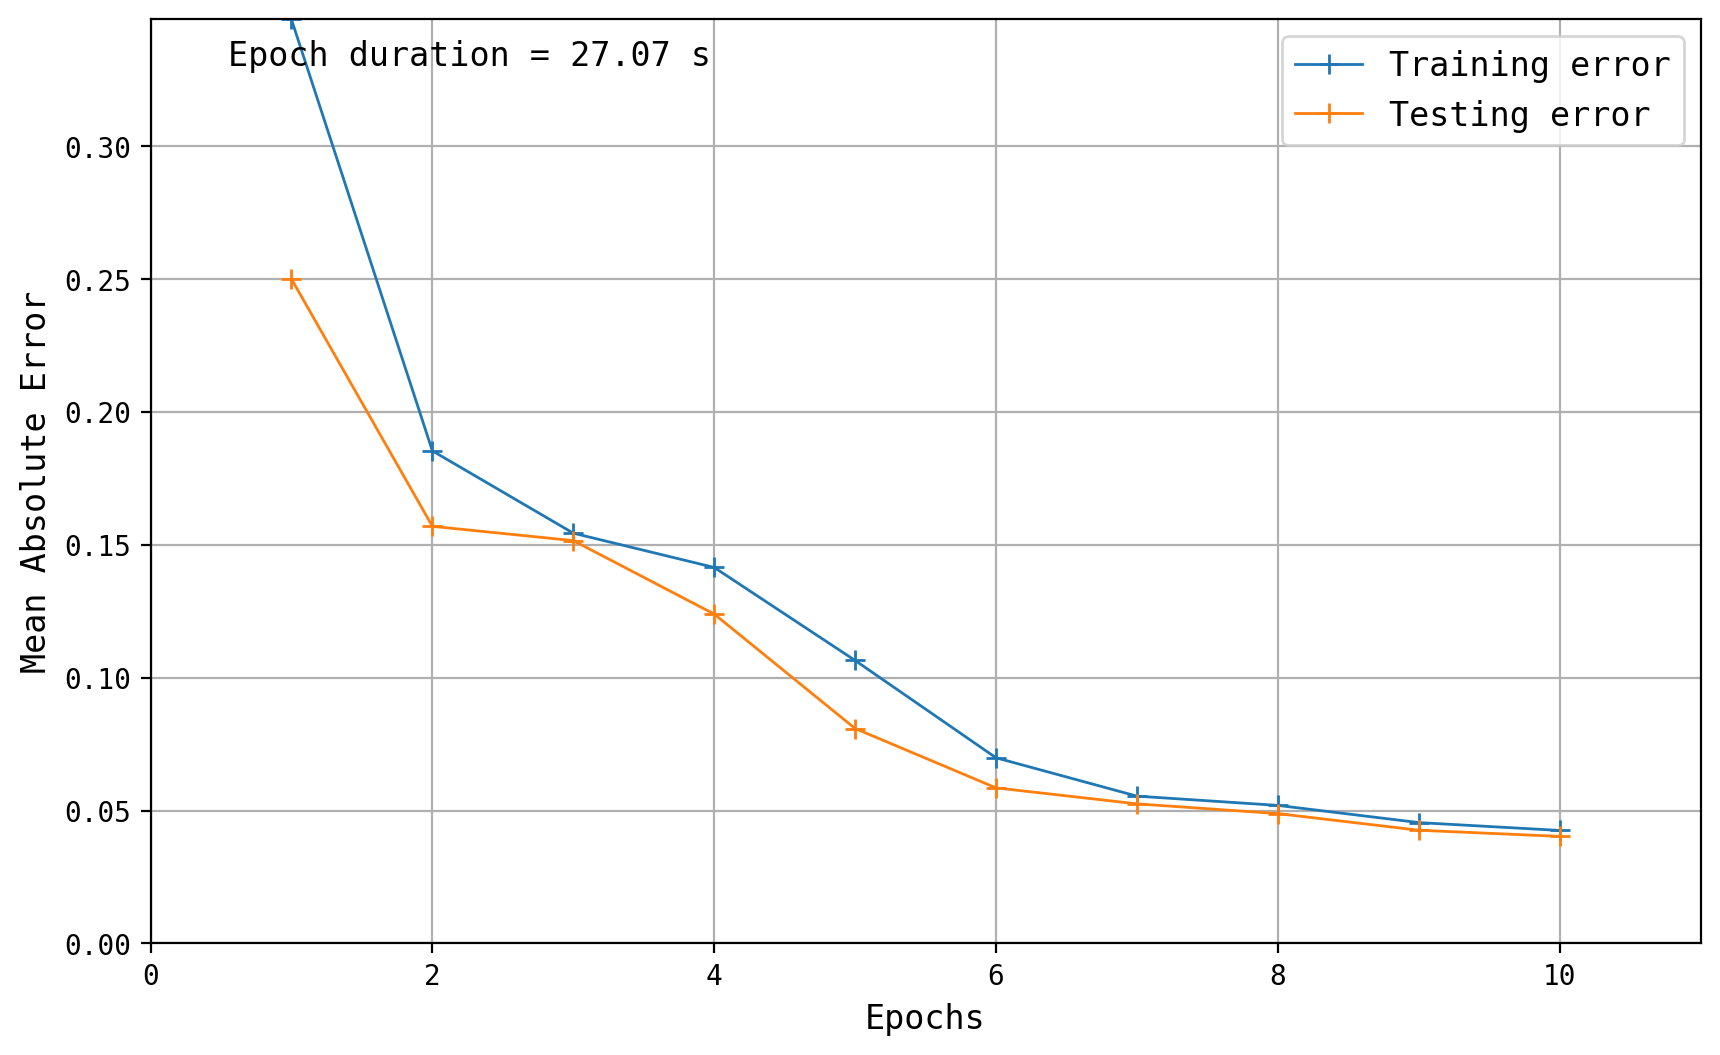

In [8]:
# training 
# possibility to resume training if Python kernel is active (execute this cell only)

n_epochs = 10

for epoch in range(n_epochs):

    t = time.time()
    training_indicator.append(train_loop(train_loader, model, criterion, optimizer))
    training_time.append(time.time() - t)

    t = time.time()
    testing_indicator.append(test_loop(test_loader, model))
    testing_time.append(time.time() - t)
    
    plot.learning(training_indicator, testing_indicator, training_time[epoch])

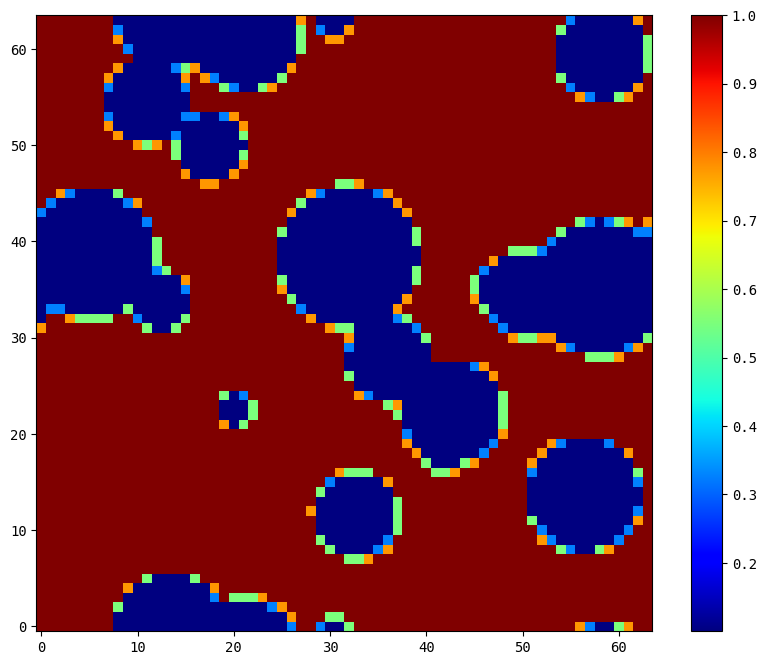

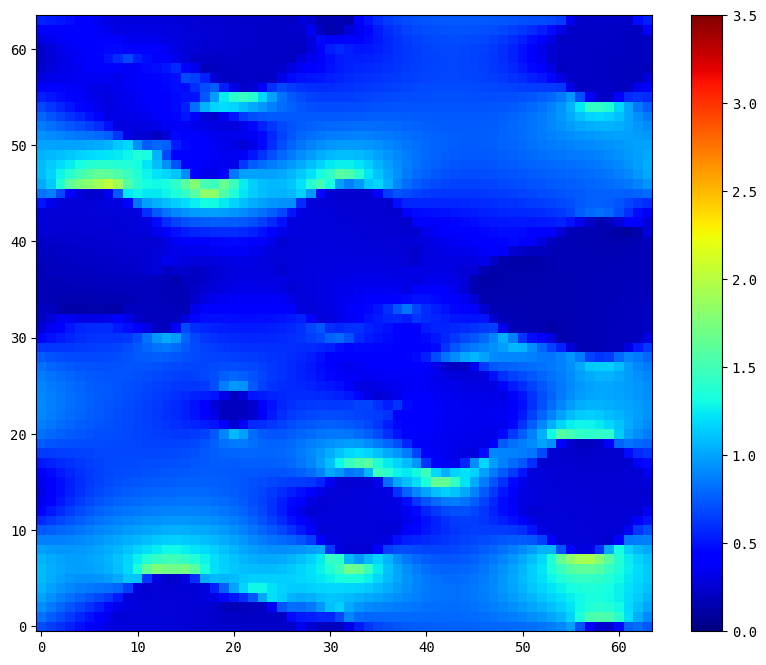

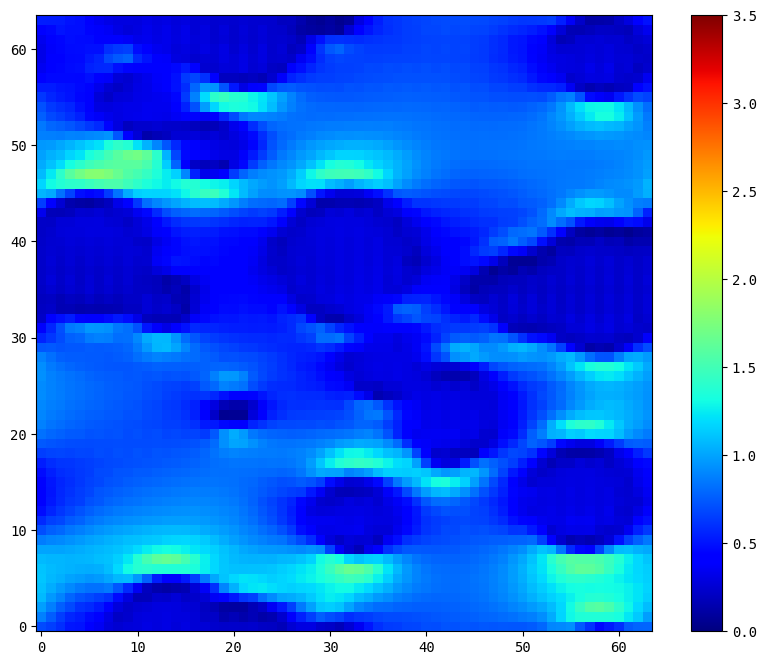

0.06797955930233002


In [9]:
indicator = torch.zeros((len(test_loader), batch_size))
with torch.no_grad():
    for batch, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        indicator[batch, :] = torch.abs(output - target).mean((1, 2, 3))

index = torch.argmax(indicator)

input = test_loader.dataset[index][0]
target = test_loader.dataset[index][1]
output = model(input.to(device).unsqueeze(0)).detach()

plot.surface(input[0, ...])
plot.surface(target[0, ...], vmin=0, vmax=3.5)
plot.surface(output[0, 0, ...], vmin=0, vmax=3.5)
print(indicator.flatten()[index].item())

In [10]:
# save model
torch.jit.script(model).save('model_scripted.pt')
torch.save(model.state_dict(), 'model.pt')

In [11]:
# load model
model = torch.jit.load('model_scripted.pt').to(device)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>